# **Data Visualization and Exploration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix


**Printed 2 rows for sanity check to identify all the features present in the dataset
and if the target matches with them.**

In [ ]:

#/content/airfoil_self_noise.dat
data = pd.read_csv('/content/airfoil_self_noise.dat',header=None, sep='\s+',names=["Frequency", "Angle of attack", "Chord_length", "Free-stream velocity","Suction wide","pressure level"], engine='python')
#data.head()
data[0:2]

,Frequency,Angle of attack,Chord_length,Free-stream velocity,Suction wide,pressure level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201


In [ ]:
#data.info()

**As we can see that below that data is balanced for pressure level. it's not biased towards any one range and distributed uniformly through out the data.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f205b811310>,
      dtype=object)

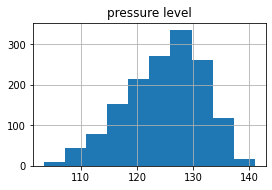

In [ ]:
data.hist(column='pressure level',figsize=(15,30),layout=(9,3))

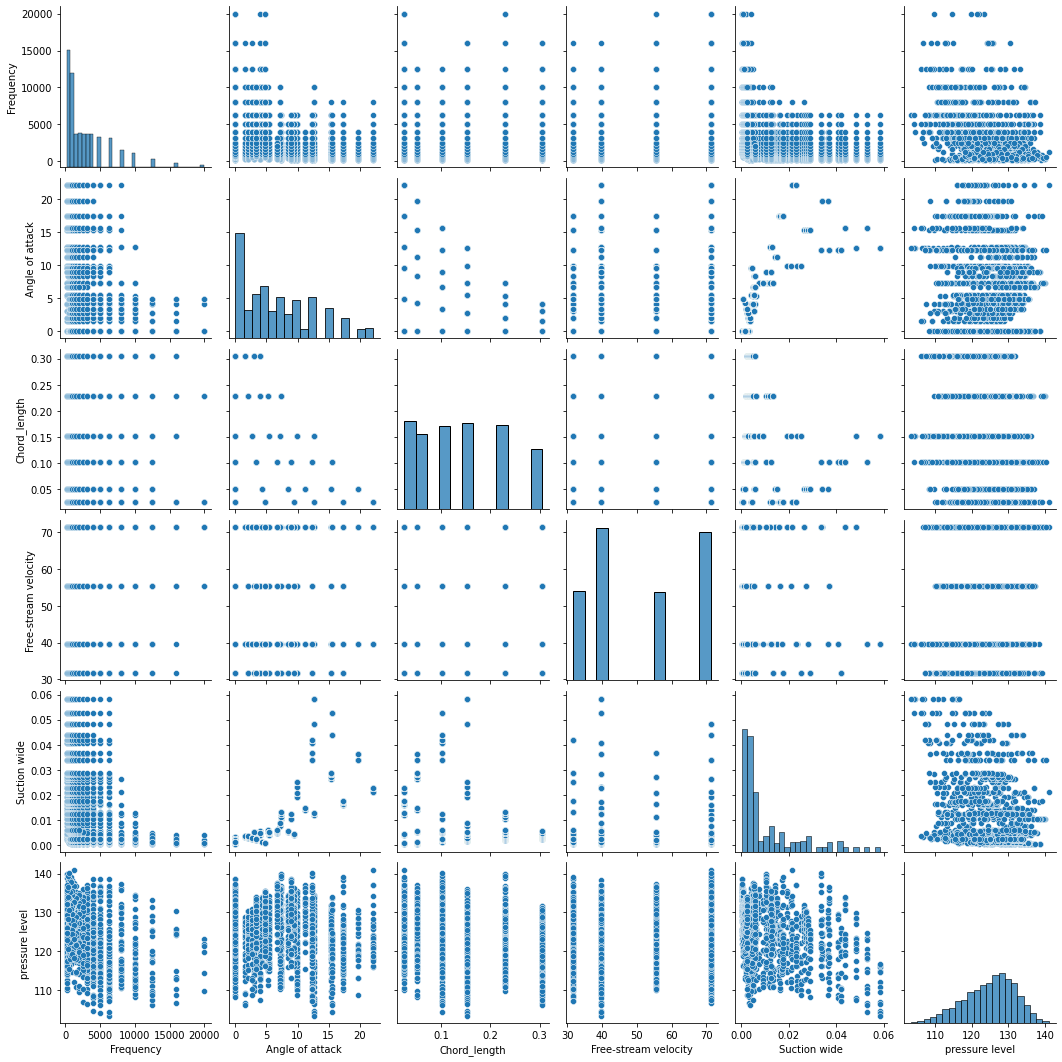

In [ ]:
sns.pairplot(data)

**We can see below from table that except Free-stream velocity attribute other attributes somewhat negatively correlated with pressure level which is our target class.**

In [ ]:
data.corr()

,Frequency,Angle of attack,Chord_length,Free-stream velocity,Suction wide,pressure level
Frequency,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Angle of attack,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Chord_length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Free-stream velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Suction wide,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
pressure level,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


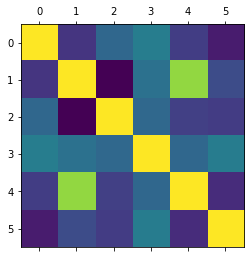

In [ ]:
plt.matshow(data.corr())
plt.show()

In [ ]:
# Checking for missing values in the dataset
data.isnull().sum()

Frequency               0
Angle of attack         0
Chord_length            0
Free-stream velocity    0
Suction wide            0
pressure level          0
dtype: int64

**We apply a dimension reduction technique to replace the feature Angle of attack, Suction wide thickness by a principle component that best represents them, as it's clear,this new componenent explains almost all variance of these two features and best represents them, it would make sense to omit these two feature and introduce the principle component instead.**

In [ ]:
pca = PCA(n_components=1)
pca.fit(np.array(data[["Angle of attack","Suction wide"]]))
print("variance explained : ",pca.explained_variance_ratio_)

y = pca.transform(np.array(data[["Angle of attack","Suction wide"]]))
new_component = pd.DataFrame(y)
new_component = new_component.rename(columns={0: 'New component'})
data["New component"] = new_component
del data["Angle of attack"]
del data["Suction wide"]
print('As we can see the new component omitted some of the colinearity.')

variance explained :  [0.99999787]
As we can see the new component omitted some of the colinearity.


In [ ]:
data.corr()

,Frequency,Chord_length,Free-stream velocity,pressure level,New component
Frequency,1.000000,-0.003661,0.133664,-0.390711,-0.272765
Chord_length,-0.003661,1.000000,0.003787,-0.236162,-0.504868
Free-stream velocity,0.133664,0.003787,1.000000,0.125103,0.058759
pressure level,-0.390711,-0.236162,0.125103,1.000000,-0.156108
New component,-0.272765,-0.504868,0.058759,-0.156108,1.000000


In [ ]:
# Extract y vector from the dataframe
y = data['pressure level']
X = data.drop('pressure level', axis=1)

*** Case 1 : Train = 80 % Test = 20% ***

In [ ]:
# spliting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [ ]:
print("Size of train data : ", X_train.shape)
print("Size of test data : ", X_test.shape)

Size of train data :  (1202, 4)
Size of test data :  (301, 4)


In [ ]:
# Linear model object instantiation
lr = LinearRegression().fit(X_train, y_train)
predictions = lr.predict(X_test)

***Evaluating the model.
Calculating the Mean Absoluate Error value to evaluate the prediction.***

In [ ]:
mae = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 3.99


**As we can see below prediction we are getting once run the model and it's not overfitting or underfitting. It's giving result but having mean absolute error 3.99. Predicted value is giving approx values with having some mean absolute error.**

In [ ]:
pred_series = pd.Series(predictions, name="Predicted")
submission = pd.concat([data, pred_series], axis=1)
submission.head()

,Frequency,Chord_length,Free-stream velocity,pressure level,New component,Predicted
0,800,0.3048,71.3,126.201,-6.782307,110.194775
1,1000,0.3048,71.3,125.201,-6.782307,129.335607
2,1250,0.3048,71.3,125.951,-6.782307,123.581227
3,1600,0.3048,71.3,127.591,-6.782307,132.142391
4,2000,0.3048,71.3,127.461,-6.782307,123.241567


*** Case 2 : Train = 10 % Test = 90% ***

In [ ]:
# spliting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=40)

In [ ]:
print("Size of train data : ", X_train.shape)
print("Size of test data : ", X_test.shape)

Size of train data :  (150, 4)
Size of test data :  (1353, 4)


In [ ]:
# Linear model object instantiation
lr = LinearRegression().fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsmae = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 4.0


**As we can see below prediction we are getting once run the model and it's not overfitting or underfitting. It's giving result but having mean absolute error 4.0 . Predicted value is giving approx values with having some mean absolute error.**

In [ ]:
pred_series = pd.Series(predictions, name="Predicted")
submission = pd.concat([data, pred_series], axis=1)
submission.head()

,Frequency,Chord_length,Free-stream velocity,pressure level,New component,Predicted
0,800,0.3048,71.3,126.201,-6.782307,109.277421
1,1000,0.3048,71.3,125.201,-6.782307,129.085253
2,1250,0.3048,71.3,125.951,-6.782307,123.383177
3,1600,0.3048,71.3,127.591,-6.782307,131.270698
4,2000,0.3048,71.3,127.461,-6.782307,122.429460


**Explore k-fold cross validation.**

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# Lets split the data into 5 folds.
# We will use this 'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
count = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{count}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    count += 1

Fold:1, Train set: 1202, Test set:301
Fold:2, Train set: 1202, Test set:301
Fold:3, Train set: 1202, Test set:301
Fold:4, Train set: 1203, Test set:300
Fold:5, Train set: 1203, Test set:300


In [ ]:
"""
Why we are using '-' sign to calculate RMSE?
ANS: Classification accuracy is reward function, means something you want to maximize. Mean Square Error is loss function,
means something you want to minimize. Now if we use 'cross_val_score' function then best score(high value) will give worst
model in case of loss function! There are other sklearn functions which also depends on 'cross_val_score' to select best model by
looking for highest scores, so a design decision was made for 'cross_val_score' to negate the output of all loss function.
So that when other sklearn function calls 'cross_val_score' those function can always assume that highest score indicate better model.
In short ignore the negative sign and rate the error based on its absolute value.
"""
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [ ]:
score = cross_val_score(LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-24.41301061 -23.21953925 -23.6277149  -26.42522573 -26.3310357 ]
rmse= 4.98


In [ ]:
%%shell
jupyter nbconvert --to html /content/Group50_Airfoil_Self_noise.ipynb

[NbConvertApp] Converting notebook /content/Group50_Airfoil_Self_noise.ipynb to html
[NbConvertApp] Writing 654433 bytes to /content/Group50_Airfoil_Self_noise.html
